In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import lightning as L
import os
import cv2
import torch
import torch.nn as nn
import transformers
import torch.nn.functional as F

from torchmetrics import Accuracy, F1Score
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import ViTModel, ViTForImageClassification
from torchvision import models
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

In [82]:
df_dir = "csv"
df_paths = os.listdir(df_dir)

In [83]:
img_dir = "image"
df = []

for df_path in df_paths:
    img_path = df_path.replace(".csv", "")
    df_cat = pd.read_csv(f"{df_dir}/{df_path}")
    df_cat['img_path'] = df_cat.apply(lambda x: f"{img_dir}/{img_path}/{x.name}.png" if os.path.exists(f"{img_dir}/{img_path}/{x.name}.png") else np.nan, axis=1)
    df.append(df_cat)

df = pd.concat(df).reset_index(drop=True)

In [84]:
df = df.dropna(axis=0)

In [85]:
category_mapping = {"sandals": "sandals_and_flip_flops",
                    "sneakers_2": "sneakers",
                    "flip_flops": "sandals_and_flip_flops",
                    "slip_on": "slip_on_and_espadrilles",
                    "slip_on_&_espadrilles": "slip_on_and_espadrilles",
                    "sepatu_sandal_and_flipflop": "sandals_and_flip_flops",
                    "sandal_and_flip_flop_2": "sandals_and_flip_flops"}

In [86]:
df["category"] = df["category"].apply(lambda x: category_mapping[x] if x in category_mapping.keys() else x)

In [87]:
brands = [
    "Guess", "Havaianas", "Wrangler", "Dr. Martens", "ALDO", "Birkenstock",
    "CHRISTIAN LOUBOUTIN", "Clarks", "Dior", "Lacoste", "Melissa", "Nike",
    "Superdry", "VANS", "Skechers", "TIMEX", "Converse", "Wacoal",
    "Salt n Pepper", "Rockport", "Hush Puppies", "FILA", "ESPRIT", "ADIDAS",
    "Crocs", "Volcom", "Samsonite", "New Balance", "Lois Jeans", "Mango",
    "Rip Curl", "Tolliver", "Preview Itang Yunasz", "NICHOLAS EDISON",
    "Maybelline", "HUER", "Palomino", "Puma", "Reebok", "Billabong", "Levi's",
    "Yongki Komaladi", "Casio", "Alba", "3SECOND", "GREENLIGHT", "Herschel",
    "Wakai", "Tatuis", "Edifice", "Alexandre Christie", "BONIA", "Timberland",
    "Fossil", "Zalia", "ZALORA", "MANGO Man", "Aira Muslim Butik",
    "Salsabila Etnic Kebaya", "Rianty Batik", "Batik Putra Bengawan", "Rubi",
    "Cressida", "Les Catino", "Bvlgari", "Coach", "Samsung", "MICHAEL KORS",
    "Burberry", "Gucci", "Call It Spring", "Daniel Wellington",
    "Yves Saint Laurent", "Quiksilver", "Chanel", "Gobelini", "DC",
    "Love, Bonito", "bhatara batik", "Fjallraven Kanken",
    "Kamilaa by Itang Yunasz", "Keds", "Carvil", "Under Armour", "Baby-G",
    "G-Shock", "Cotton On", "Anello", "Abercrombie & Fitch", "Hollister",
    "Thule", "Lojel", "Pandora", "Avoskin", "Cool Kids", "Tory Burch",
    "New Era", "BOSS", "Polo Ralph Lauren", "MLB", "LONGCHAMP", "On",
    "BALENCIAGA", "Louis Vuitton", "Gentle Monster", "Acme De La Vie",
    "Christian Dior", "Jo Malone", "Somethinc", "2XU", "Corkcicle", "H&M",
    "MIU MIU", "Givenchy", "BOTTEGA VENETA", "Off-White", "PAYLESS",
    "LI-NING", "Smiggle", "Fred Perry", "HANASUI", "ZARA", "Roughneck 1991",
    "JACO", "MLB Korea", "Mardi Mercredi", "GENTLEWOMAN", "Loro Piana",
    "SENNHEISER", "Goyard"
]

df = df[df["brand"].isin(brands)]

In [88]:
df = df[df["brand"].isin((df["brand"].value_counts())[(df["brand"].value_counts() > 280)].index)]

In [89]:
cat_enc = LabelEncoder()
brand_enc = LabelEncoder()

df["category"] = cat_enc.fit_transform(df["category"])
df["brand"] = brand_enc.fit_transform(df["brand"])

In [90]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

In [91]:
class CategoryDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.img_path = df['img_path']
        self.category = df['category']
        self.brand = df["brand"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path.iloc[idx])
        img = torch.tensor(cv2.resize(img, (224, 224)), dtype=torch.float32).permute(-1, 0, 1)
        category = torch.tensor(self.category.iloc[idx], dtype=torch.long)
        brand = torch.tensor(self.brand.iloc[idx], dtype=torch.long)

        return img, category, brand

In [92]:
train_set = CategoryDataset(train_df)
val_set = CategoryDataset(val_df)
test_set = CategoryDataset(test_df)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

In [47]:
models.vit_l_32().heads.head

Linear(in_features=1024, out_features=1000, bias=True)

## VIT KONTOL

In [48]:
# class MultiLabelHead(nn.Module):
#     def __init__(self, in_features, n_category, n_brand):
#         super(MultiLabelHead, self).__init__()
#         self.n_category = n_category
#         self.n_brand = n_brand

#         self.fc_cat = nn.Linear(in_features, n_category)
#         self.fc_brand = nn.Linear(in_features, n_brand)

#     def forward(self, input):
#         cat_logits = self.fc_cat(input)
#         brand_logits = self.fc_brand(input)

#         return cat_logits, brand_logits

# class VIT(L.LightningModule):
#     def __init__(self, n_category, n_brand):
#         super(VIT, self).__init__()
#         self.n_category = n_category
#         self.n_brand = n_brand

#         self.vit = models.vit_l_32(weights=models.ViT_L_32_Weights)
#         self.head = MultiLabelHead(self.vit.heads.head.in_features, self.n_category, self.n_brand)
#         self.vit.heads = self.head
#         self.accuracy_cat = Accuracy(task="multiclass", num_classes=self.n_category)
#         self.accuracy_brand = Accuracy(task="multiclass", num_classes=self.n_brand)
#         self.f1_cat = F1Score(task="multiclass", num_classes=self.n_category, average="macro")
#         self.f1_brand = F1Score(task="multiclass", num_classes=self.n_brand, average="macro")
#         self.criterion_cat = nn.CrossEntropyLoss()
#         self.criterion_brand = nn.CrossEntropyLoss()

#         self.train_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}
#         self.val_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}
#         self.test_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}

#         self.train_step_loss = []
#         self.train_epochs_loss = []
#         self.train_epochs_cat_acc = []
#         self.train_epochs_cat_f1 = []
#         self.train_epochs_brand_acc = []
#         self.train_epochs_brand_f1 = []
#         self.train_epochs_exact_match_ratio = []

#         self.val_step_loss = []
#         self.val_epochs_loss = []
#         self.val_epochs_cat_acc = []
#         self.val_epochs_cat_f1 = []
#         self.val_epochs_brand_acc = []
#         self.val_epochs_brand_f1 = []
#         self.val_epochs_exact_match_ratio = []

#     def forward(self, pixel_values):
#         cat_logits, brand_logits = self.vit(pixel_values)

#         return cat_logits, brand_logits
    
#     def _common_step(self, batch, batch_idx):
#         img, category, brand = batch
#         cat_pred, brand_pred = self.forward(img)
#         loss_cat = self.criterion_cat(cat_pred, category)
#         loss_brand = self.criterion_cat(brand_pred, brand)
#         loss = loss_cat + loss_brand

#         return loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand
    
#     def on_train_start(self):
#         self.train_step_loss.clear()
#         self.val_step_loss.clear()
    
#     def training_step(self, batch, batch_idx):
#         loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
#         self.log('train_loss', loss, prog_bar=True)
#         self.log('train_cat_loss', loss_cat)
#         self.log('train_brand_loss', loss_brand)

#         self.train_output["cat_pred"].append(cat_pred.argmax(dim=-1))
#         self.train_output["cat_actual"].append(category)
#         self.train_output["brand_pred"].append(brand_pred.argmax(dim=-1))
#         self.train_output["brand_actual"].append(brand)

#         self.train_step_loss.append(loss.item())
#         return loss
    
#     def validation_step(self, batch, batch_idx):
#         loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
#         self.log('val_loss', loss, prog_bar=True)
        
#         self.val_output["cat_pred"].append(cat_pred.argmax(dim=-1))
#         self.val_output["cat_actual"].append(category)
#         self.val_output["brand_pred"].append(brand_pred.argmax(dim=-1))
#         self.val_output["brand_actual"].append(brand)

#         self.val_step_loss.append(loss.item())
#         return self.val_output, self.val_step_loss
    
#     def test_step(self, batch, batch_idx):
#         loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
#         self.log('test_loss', loss, prog_bar=True)

#         self.test_output["cat_pred"].append(cat_pred.argmax(dim=-1))
#         self.test_output["cat_actual"].append(category)
#         self.test_output["brand_pred"].append(brand_pred.argmax(dim=-1))
#         self.test_output["brand_actual"].append(brand)
#         return self.test_output
    
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
#         return {
#             "optimizer": optimizer,
#             "lr_scheduler": {
#                 "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
#                     optimizer
#                 ),
#                 "monitor": "val_loss",
#             }
#         }
    
#     def predict_step(self, batch, batch_idx):
#         img, category, brand = batch
#         cat_pred, brand_pred = self.forward(img)

#         return cat_pred, brand_pred
    
#     def on_train_epoch_end(self):
#         cat_pred = torch.cat(self.train_output["cat_pred"])
#         cat_actual = torch.cat(self.train_output["cat_actual"])
#         brand_pred = torch.cat(self.train_output["brand_pred"])
#         brand_actual = torch.cat(self.train_output["brand_actual"])

#         cat_f1_score = self.f1_cat(cat_pred, cat_actual)
#         cat_accuracy_score = self.accuracy_cat(cat_pred, cat_actual)
#         brand_f1_score = self.f1_brand(brand_pred, brand_actual)
#         brand_accuracy_score = self.accuracy_brand(brand_pred, brand_actual)
#         exact_match_ratio = np.mean((cat_pred.cpu().numpy() == cat_actual.cpu().numpy()) & (brand_pred.cpu().numpy() == brand_actual.cpu().numpy()))

#         self.train_epochs_cat_acc.append(cat_accuracy_score)
#         self.train_epochs_cat_f1.append(cat_f1_score)
#         self.train_epochs_brand_acc.append(brand_accuracy_score)
#         self.train_epochs_brand_f1.append(brand_f1_score)
#         self.train_epochs_exact_match_ratio.append(exact_match_ratio)
#         self.train_epochs_loss.append(np.mean(self.train_step_loss))

#         self.train_output["cat_pred"].clear()
#         self.train_output["cat_actual"].clear()
#         self.train_output["brand_pred"].clear()
#         self.train_output["brand_actual"].clear()
#         self.train_step_loss.clear()
    
#     def on_validation_epoch_end(self):
#         cat_pred = torch.cat(self.val_output["cat_pred"])
#         cat_actual = torch.cat(self.val_output["cat_actual"])
#         brand_pred = torch.cat(self.val_output["brand_pred"])
#         brand_actual = torch.cat(self.val_output["brand_actual"])

#         cat_f1_score = self.f1_cat(cat_pred, cat_actual)
#         cat_accuracy_score = self.accuracy_cat(cat_pred, cat_actual)
#         brand_f1_score = self.f1_brand(brand_pred, brand_actual)
#         brand_accuracy_score = self.accuracy_brand(brand_pred, brand_actual)
#         exact_match_ratio = np.mean((cat_pred.cpu().numpy() == cat_actual.cpu().numpy()) & (brand_pred.cpu().numpy() == brand_actual.cpu().numpy()))

#         print(f'\nCategory f1_score: {cat_f1_score} | Category accuracy: {cat_accuracy_score}')
#         print(f'Brand f1_score: {brand_f1_score} | Brand accuracy: {brand_accuracy_score}')
#         print(f'Exact match ratio: {exact_match_ratio}')

#         self.val_epochs_cat_acc.append(cat_accuracy_score)
#         self.val_epochs_cat_f1.append(cat_f1_score)
#         self.val_epochs_brand_acc.append(brand_accuracy_score)
#         self.val_epochs_brand_f1.append(brand_f1_score)
#         self.val_epochs_exact_match_ratio.append(exact_match_ratio)
#         self.val_epochs_loss.append(np.mean(self.val_step_loss))

#         self.val_output["cat_pred"].clear()
#         self.val_output["cat_actual"].clear()
#         self.val_output["brand_pred"].clear()
#         self.val_output["brand_actual"].clear()
#         self.val_step_loss.clear()

#     def on_test_epoch_end(self):
#         cat_pred = torch.cat(self.test_output["cat_pred"]).tolist()
#         cat_actual = torch.cat(self.test_output["cat_actual"]).tolist()
#         brand_pred = torch.cat(self.test_output["brand_pred"]).tolist()
#         brand_actual = torch.cat(self.test_output["brand_actual"]).tolist()
        
#         print('\nCategory Metrics')
#         print(classification_report(cat_actual, cat_pred))
#         cm = confusion_matrix(cat_actual, cat_pred)
#         dis = ConfusionMatrixDisplay(cm)
        
#         dis.plot()
#         plt.show()
#         print('\nBrand Metrics')
#         print(classification_report(brand_actual, brand_pred))
#         cm = confusion_matrix(brand_actual, brand_pred)
#         dis = ConfusionMatrixDisplay(cm)
        
#         dis.plot()
#         plt.show()

#         self.test_output["cat_pred"].clear()
#         self.test_output["cat_actual"].clear()
#         self.test_output["brand_pred"].clear()
#         self.test_output["brand_actual"].clear()

#     def plot_accuracy(self):
#         n_epochs = range(len(self.train_epochs_cat_acc))
#         fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#         ax[1].plot(n_epochs, self.train_epochs_cat_acc.cpu(), label="Training Accuracy (Category)")
#         ax[1].plot(n_epochs, self.val_epochs_cat_acc.cpu(), label="Validation Accuracy (Category)")
#         ax[1].legend(loc="lower right")
#         ax[1].title("Category Accuracy")

#         ax[1].plot(n_epochs, self.train_epochs_brand_acc.cpu(), label="Training Accuracy (Brand)")
#         ax[1].plot(n_epochs, self.val_epochs_brand_acc.cpu(), label="Validation Accuracy (Brand)")
#         ax[1].legend(loc="lower right")
#         ax[1].title("Brand Accuracy")

#         plt.show()

#     def plot_f1(self):
#         n_epochs = range(len(self.train_epochs_cat_f1))
#         fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
#         ax[1].plot(n_epochs, self.train_epochs_cat_f1.cpu(), label="Training F1 (Category)")
#         ax[1].plot(n_epochs, self.val_epochs_cat_f1.cpu(), label="Validation F1 (Category)")
#         ax[1].legend(loc="lower right")
#         ax[1].title("Category F1")

#         ax[1].plot(n_epochs, self.train_epochs_brand_f1.cpu(), label="Training F1 (Brand)")
#         ax[1].plot(n_epochs, self.val_epochs_brand_f1.cpu(), label="Validation F1 (Brand)")
#         ax[1].legend(loc="lower right")
#         ax[1].title("Brand F1")

#         plt.show()

#     def plot_loss(self):
#         n_epochs = range(len(self.train_epochs_loss))
#         plt.figure(figsize=(12, 6))
#         plt.plot(n_epochs, self.train_epochs_loss.cpu(), label="Training Loss")
#         plt.plot(n_epochs, self.val_epochs_loss.cpu(), label="Validation Loss")
#         plt.title("Loss")
#         plt.show()

#     def plot_exact_match_ratio(self):
#         n_epochs = range(len(self.train_epochs_exact_match_ratio))
#         plt.figure(figsize=(12, 6))
#         plt.plot(n_epochs, self.train_epochs_exact_match_ratio.cpu(), label="Training Exact Match Ratio")
#         plt.plot(n_epochs, self.val_epochs_exact_match_ratio.cpu(), label="Validation Exact Match Ratio")
#         plt.title("Exact Match Ratio")
#         plt.show()

#     def plot_scores(self, score):
#         if score == "accuracy":
#             self.plot_accuracy()
#         elif score == "f1":
#             self.plot_f1()
#         elif score == "loss":
#             self.plot_loss()
#         elif score == "exact match ratio":
#             self.plot_exact_match_ratio()
            

In [49]:
# n_category = len(cat_enc.classes_)
# n_brand = len(brand_enc.classes_)

# model = VIT(n_category, n_brand)

In [50]:
# for i, (img, category, brand) in enumerate(train_loader):
#     print(model(img)[0].shape)
#     break

In [51]:
# early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=False, mode="min")
# trainer = L.Trainer(accelerator="gpu", devices=[0], max_epochs=30, callbacks=[early_stop_callback])
# trainer.fit(model, train_loader, val_loader)

## RESNET SAYANG

In [52]:
class MultiLabelHead(nn.Module):
    def __init__(self, in_features, n_category, n_brand):
        super(MultiLabelHead, self).__init__()
        self.n_category = n_category
        self.n_brand = n_brand

        self.fc_cat = nn.Linear(in_features, n_category)
        self.fc_brand = nn.Linear(in_features, n_category)

    def forward(self, input):
        cat_logits = self.fc_cat(input)
        brand_logits = self.fc_brand(input)

        return cat_logits, brand_logits

class ResNet(L.LightningModule):
    def __init__(self, n_category, n_brand):
        super(ResNet, self).__init__()
        self.n_category = n_category
        self.n_brand = n_brand

        self.resnet = models.resnet101(weights=models.ResNet101_Weights)
        self.head = MultiLabelHead(self.resnet.fc.in_features, self.n_category, self.n_brand)
        self.resnet.fc = self.head
        self.accuracy_cat = Accuracy(task="multiclass", num_classes=self.n_category)
        self.accuracy_brand = Accuracy(task="multiclass", num_classes=self.n_brand)
        self.f1_cat = F1Score(task="multiclass", num_classes=self.n_category, average="macro")
        self.f1_brand = F1Score(task="multiclass", num_classes=self.n_brand, average="macro")
        self.criterion_cat = nn.CrossEntropyLoss()
        self.criterion_brand = nn.CrossEntropyLoss()

        self.train_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}
        self.val_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}
        self.test_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}

    def forward(self, pixel_values):
        cat_logits, brand_logits = self.resnet(pixel_values)

        return cat_logits, brand_logits
    
    def _common_step(self, batch, batch_idx):
        img, category, brand = batch
        cat_pred, brand_pred = self.forward(img)
        loss_cat = self.criterion_cat(cat_pred, category)
        loss_brand = self.criterion_cat(brand_pred, brand)
        loss = loss_cat + loss_brand

        return loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand
    
    def training_step(self, batch, batch_idx):
        loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_cat_loss', loss_cat)
        self.log('train_brand_loss', loss_brand)

        self.train_output["cat_pred"].append(cat_pred.argmax(dim=-1))
        self.train_output["cat_actual"].append(category)
        self.train_output["brand_pred"].append(brand_pred.argmax(dim=-1))
        self.train_output["brand_actual"].append(brand)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        
        self.val_output["cat_pred"].append(cat_pred.argmax(dim=-1))
        self.val_output["cat_actual"].append(category)
        self.val_output["brand_pred"].append(brand_pred.argmax(dim=-1))
        self.val_output["brand_actual"].append(brand)

        return self.val_output
    
    def test_step(self, batch, batch_idx):
        loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)

        self.test_output["cat_pred"].append(cat_pred.argmax(dim=-1))
        self.test_output["cat_actual"].append(category)
        self.test_output["brand_pred"].append(brand_pred.argmax(dim=-1))
        self.test_output["brand_actual"].append(brand)
        return self.test_output
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.0001, weight_decay=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer
                ),
                "monitor": "val_loss",
            }
        }
    
    def predict_step(self, batch, batch_idx):
        img, category, brand = batch
        cat_pred, brand_pred = self.forward(img)

        return cat_pred, brand_pred
    
    def on_train_epoch_end(self):
        cat_pred = torch.cat(self.train_output["cat_pred"])
        cat_actual = torch.cat(self.train_output["cat_actual"])
        brand_pred = torch.cat(self.train_output["brand_pred"])
        brand_actual = torch.cat(self.train_output["brand_actual"])

        cat_f1_score = self.f1_cat(cat_pred, cat_actual)
        cat_accuracy_score = self.accuracy_cat(cat_pred, cat_actual)
        brand_f1_score = self.f1_brand(brand_pred, brand_actual)
        brand_accuracy_score = self.accuracy_brand(brand_pred, brand_actual)
        exact_match_ratio = np.mean((cat_pred.cpu().numpy() == cat_actual.cpu().numpy()) & (brand_pred.cpu().numpy() == brand_actual.cpu().numpy()))

        self.log("train_cat_f1", cat_f1_score)
        self.log("train_cat_accuracy", cat_accuracy_score)
        self.log("train_brand_f1", brand_f1_score)
        self.log("train_brand_accuracy", brand_accuracy_score)
        self.log("train_exact_match_ratio", exact_match_ratio)

        self.train_output["cat_pred"].clear()
        self.train_output["cat_actual"].clear()
        self.train_output["brand_pred"].clear()
        self.train_output["brand_actual"].clear()
    
    def on_validation_epoch_end(self):
        cat_pred = torch.cat(self.val_output["cat_pred"])
        cat_actual = torch.cat(self.val_output["cat_actual"])
        brand_pred = torch.cat(self.val_output["brand_pred"])
        brand_actual = torch.cat(self.val_output["brand_actual"])

        cat_f1_score = self.f1_cat(cat_pred, cat_actual)
        cat_accuracy_score = self.accuracy_cat(cat_pred, cat_actual)
        brand_f1_score = self.f1_brand(brand_pred, brand_actual)
        brand_accuracy_score = self.accuracy_brand(brand_pred, brand_actual)
        exact_match_ratio = np.mean((cat_pred.cpu().numpy() == cat_actual.cpu().numpy()) & (brand_pred.cpu().numpy() == brand_actual.cpu().numpy()))

        print(f'\nCategory f1_score: {cat_f1_score} | Category accuracy: {cat_accuracy_score}')
        print(f'Brand f1_score: {brand_f1_score} | Brand accuracy: {brand_accuracy_score}')
        print(f'Exact match ratio: {exact_match_ratio}')

        self.log("val_cat_f1", cat_f1_score)
        self.log("val_cat_accuracy", cat_accuracy_score)
        self.log("val_brand_f1", brand_f1_score)
        self.log("val_brand_accuracy", brand_accuracy_score)
        self.log("val_exact_match_ratio", exact_match_ratio)

        self.val_output["cat_pred"].clear()
        self.val_output["cat_actual"].clear()
        self.val_output["brand_pred"].clear()
        self.val_output["brand_actual"].clear()

    def on_test_epoch_end(self):
        cat_pred = torch.cat(self.test_output["cat_pred"])
        cat_actual = torch.cat(self.test_output["cat_actual"])
        brand_pred = torch.cat(self.test_output["brand_pred"])
        brand_actual = torch.cat(self.test_output["brand_actual"])

        cat_f1_score = self.f1_cat(cat_pred, cat_actual)
        cat_accuracy_score = self.accuracy_cat(cat_pred, cat_actual)
        brand_f1_score = self.f1_brand(brand_pred, brand_actual)
        brand_accuracy_score = self.accuracy_brand(brand_pred, brand_actual)

        cat_pred = cat_pred.tolist()
        cat_actual = cat_actual.tolist()
        brand_pred = brand_pred.tolist()
        brand_actual = brand_actual.tolist()

        exact_match_ratio = np.mean((np.array(cat_pred) == np.array(cat_actual)) & (np.array(brand_pred) == np.array(brand_actual)))
        self.log("test_cat_f1", cat_f1_score)
        self.log("test_cat_accuracy", cat_accuracy_score)
        self.log("test_brand_f1", brand_f1_score)
        self.log("test_brand_accuracy", brand_accuracy_score)
        self.log("test_exact_match_ratio", exact_match_ratio)
        print("Exact match ratio :", exact_match_ratio)
        
        print('\nCategory Metrics')
        print(classification_report(cat_actual, cat_pred))
        cm = confusion_matrix(cat_actual, cat_pred)
        dis = ConfusionMatrixDisplay(cm)
        
        dis.plot()
        plt.show()
        print('\nBrand Metrics')
        print(classification_report(brand_actual, brand_pred))
        cm = confusion_matrix(brand_actual, brand_pred)
        dis = ConfusionMatrixDisplay(cm)
        
        dis.plot()
        plt.show()

        self.test_output["cat_pred"].clear()
        self.test_output["cat_actual"].clear()
        self.test_output["brand_pred"].clear()
        self.test_output["brand_actual"].clear()
            

C:\Users\horas\AppData\Local\Temp\ipykernel_6652\3315956830.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.long).cpu().numpy()  # Ensure it's a NumPy array for matplotlib
C:\Users\horas\AppData\Local\Temp\ipykernel_6652\3315956830.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.long).cpu().numpy()  # Ensure it's a NumPy array for matplotlib
C:\Users\horas\AppData\Local\Temp\ipykernel_6652\3315956830.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img =

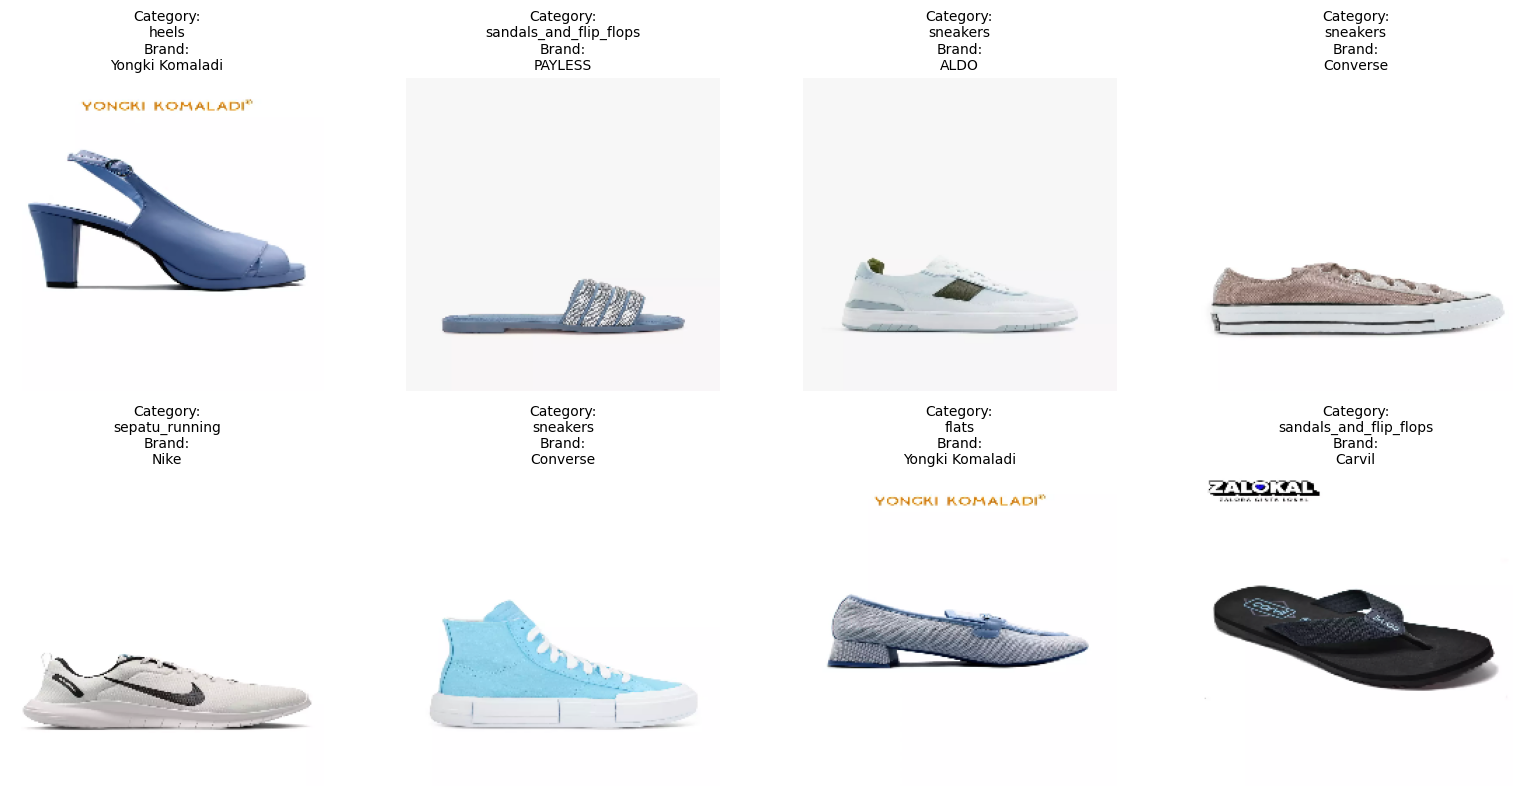

In [103]:
def visualize_data(loader, num_images=10):
    data_iter = iter(loader)
    images, categories, brands = next(data_iter)  # Unpack the batch
    
    columns = 4  # Number of columns
    rows = (num_images + columns - 1) // columns  # Calculate number of rows based on images
    plt.figure(figsize=(columns * 4, rows * 4))  # Adjust figure size based on rows and columns

    for i in range(min(num_images, len(images))):
        img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = torch.tensor(img, dtype=torch.long).cpu().numpy()  # Ensure it's a NumPy array for matplotlib
        category = categories[i]
        brand = brands[i]
        
        plt.subplot(rows, columns, i + 1)  # Configure subplot grid
        plt.imshow(img)
        plt.title(f"Category:\n{cat_enc.inverse_transform([category])[0]}\nBrand:\n{brand_enc.inverse_transform([brand])[0]}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_data(train_loader)


In [187]:
resnet101_metrics = pd.read_csv('metrics/resnet101.csv')
vit_metrics = pd.read_csv('metrics/vit.csv')
maxvit_metrics = pd.read_csv('metrics/maxvit.csv')
convnext_metrics = pd.read_csv('metrics/convnext.csv')
densenet_metrics = pd.read_csv('metrics/densenet.csv')

In [188]:
train_col = ['train_brand_accuracy', 'train_brand_f1', 'train_cat_accuracy', 'train_cat_f1', 'train_exact_match_ratio']
train_col_loss = ['train_brand_loss', 'train_cat_loss', 'train_loss']
val_col = ['val_brand_accuracy', 'val_brand_f1', 'val_cat_accuracy', 'val_cat_f1', 'val_exact_match_ratio', 'val_loss']
test_col = ['test_brand_accuracy', 'test_brand_f1', 'test_cat_accuracy', 'test_cat_f1', 'test_exact_match_ratio', 'test_loss']

In [189]:
resnet101_test = resnet101_metrics.iloc[resnet101_metrics[test_col].dropna(how="all").index][["epoch"] + test_col]
vit_test = vit_metrics.iloc[vit_metrics[test_col].dropna(how="all").index][["epoch"] + test_col]
maxvit_test = maxvit_metrics.iloc[maxvit_metrics[test_col].dropna(how="all").index][["epoch"] + test_col]
convnext_test = convnext_metrics.iloc[convnext_metrics[test_col].dropna(how="all").index][["epoch"] + test_col]
densenet_test = densenet_metrics.iloc[densenet_metrics[test_col].dropna(how="all").index][["epoch"] + test_col]

In [190]:
resnet101_test['model'] = "resnet101"
vit_test['model'] = "vit"
maxvit_test['model'] = "maxvit"
convnext_test['model'] = "convnext"
densenet_test['model'] = "densenet"

In [194]:
pd.concat([densenet_test, resnet101_test, vit_test, maxvit_test, convnext_test])

,epoch,test_brand_accuracy,test_brand_f1,test_cat_accuracy,test_cat_f1,test_exact_match_ratio,test_loss,model
141,7,0.884742,0.856791,0.832053,0.521200,0.731065,0.895501,densenet
262,13,0.886937,0.858193,0.798024,0.494545,0.694841,1.193494,resnet101
424,21,0.756312,0.739156,0.736553,0.431088,0.555434,1.867777,vit
202,10,0.937431,0.920586,0.794731,0.525703,0.737651,0.844331,maxvit
141,7,0.930845,0.921963,0.815587,0.595767,0.755214,0.790277,convnext


In [157]:
train_loss = convnext_metrics.iloc[convnext_metrics[train_col_loss].dropna(how="all").index][["epoch"] + train_col_loss]
train_metrics = convnext_metrics.iloc[convnext_metrics[train_col].dropna(how="all").index][["epoch"] + train_col]
val_metrics = convnext_metrics.iloc[convnext_metrics[val_col].dropna(how="all").index][["epoch"] + val_col]
test_metrics = convnext_metrics.iloc[convnext_metrics[test_col].dropna(how="all").index][["epoch"] + test_col]

In [158]:
train_loss = train_loss.groupby(by="epoch").mean()

In [ ]:
train_brand_accuracy = train_metrics["train_brand_accuracy"]
train_cat_accuracy = train_metrics["train_cat_accuracy"]

In [170]:
val_brand_accuracy = val_metrics["val_brand_accuracy"]
val_cat_accuracy = val_metrics["val_cat_accuracy"]

In [176]:
train_brand_f1 = train_metrics["train_brand_f1"]
train_cat_f1 = train_metrics["train_cat_f1"]
val_brand_f1 = val_metrics["val_brand_f1"]
val_cat_f1 = val_metrics["val_cat_f1"]

In [179]:
train_loss_v = train_loss["train_loss"]
val_loss_v = val_metrics["val_loss"]

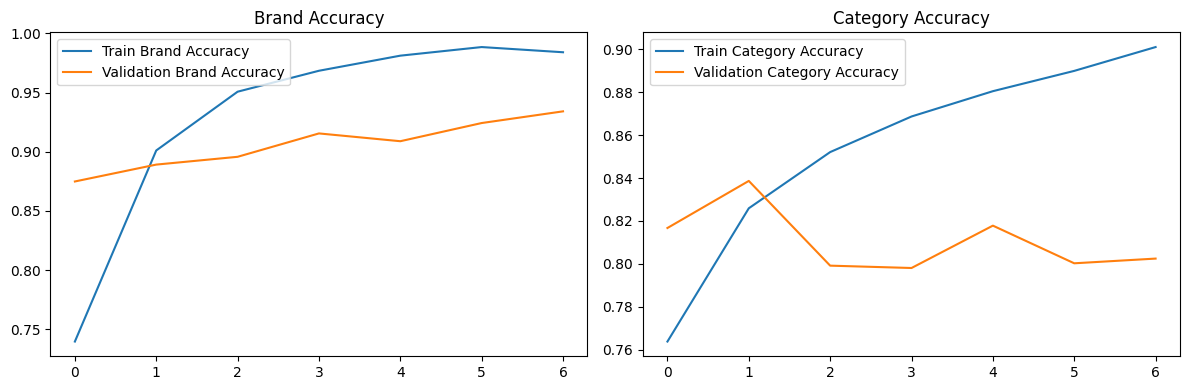

In [175]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot Brand Accuracy
ax[0].plot(range(len(train_brand_accuracy)), train_brand_accuracy, label='Train Brand Accuracy')
ax[0].plot(range(len(val_brand_accuracy)), val_brand_accuracy, label='Validation Brand Accuracy')
ax[0].set_title('Brand Accuracy')  # Add title for Brand
ax[0].legend(loc = "upper left")  # Add legend

# Plot Category Accuracy
ax[1].plot(range(len(train_cat_accuracy)), train_cat_accuracy, label='Train Category Accuracy')
ax[1].plot(range(len(val_cat_accuracy)), val_cat_accuracy, label='Validation Category Accuracy')
ax[1].set_title('Category Accuracy')  # Add title for Category
ax[1].legend(loc = "upper left")  # Add legend

# Overall adjustments
fig.tight_layout()
plt.show()


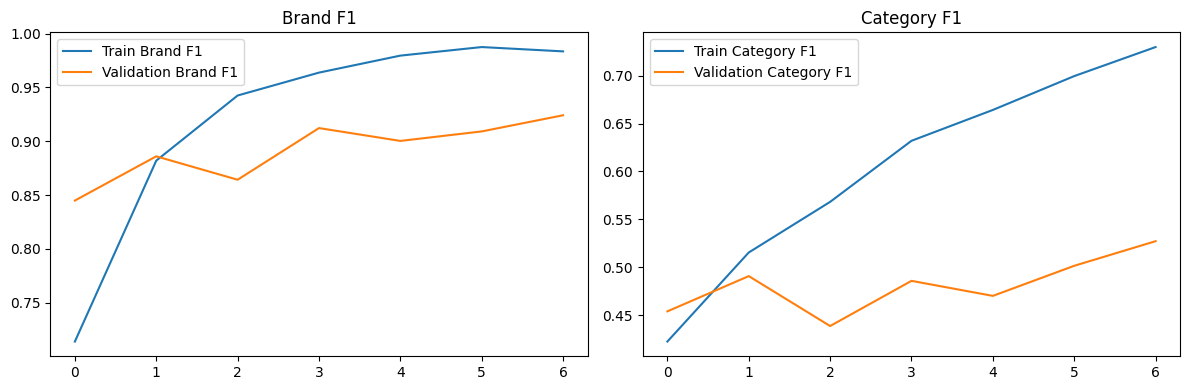

In [177]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot Brand Accuracy
ax[0].plot(range(len(train_brand_f1)), train_brand_f1, label='Train Brand F1')
ax[0].plot(range(len(val_brand_f1)), val_brand_f1, label='Validation Brand F1')
ax[0].set_title('Brand F1')  # Add title for Brand
ax[0].legend(loc = "upper left")  # Add legend

# Plot Category f1
ax[1].plot(range(len(train_cat_f1)), train_cat_f1, label='Train Category F1')
ax[1].plot(range(len(val_cat_f1)), val_cat_f1, label='Validation Category F1')
ax[1].set_title('Category F1')  # Add title for Category
ax[1].legend(loc = "upper left")  # Add legend

# Overall adjustments
fig.tight_layout()
plt.show()


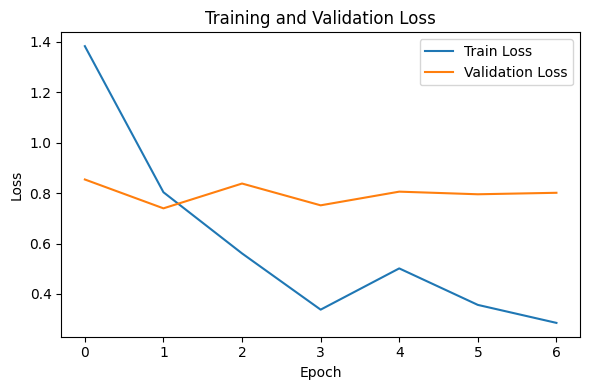

In [186]:
plt.figure(figsize=(6, 4))

# Plot training and validation loss
plt.plot(range(len(train_loss_v)), train_loss_v, label='Train Loss')
plt.plot(range(len(val_loss_v)), val_loss_v, label='Validation Loss')

# Add title and legend
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')  # Position the legend

# Show the plot
plt.tight_layout()
plt.show()


In [182]:
val_loss_v

18     0.854133
38     0.739672
58     0.838052
78     0.751616
99     0.805861
119    0.795471
139    0.801357
Name: val_loss, dtype: float64

In [63]:
class ResNet101(L.LightningModule):
    def __init__(self, n_category, n_brand):
        super(ResNet101, self).__init__()
        self.save_hyperparameters()
        self.n_category = n_category
        self.n_brand = n_brand

        self.resnet = models.resnet101(weights=models.ResNet101_Weights)
        self.head = MultiLabelHead(self.resnet.fc.in_features, self.n_category, self.n_brand)
        self.resnet.fc = self.head
        self.accuracy_cat = Accuracy(task="multiclass", num_classes=self.n_category)
        self.accuracy_brand = Accuracy(task="multiclass", num_classes=self.n_brand)
        self.f1_cat = F1Score(task="multiclass", num_classes=self.n_category, average="macro")
        self.f1_brand = F1Score(task="multiclass", num_classes=self.n_brand, average="macro")
        self.criterion_cat = nn.CrossEntropyLoss()
        self.criterion_brand = nn.CrossEntropyLoss()

        self.train_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}
        self.val_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}
        self.test_output = {"cat_pred": [], "cat_actual": [], "brand_pred": [], "brand_actual": []}

    def forward(self, pixel_values):
        cat_logits, brand_logits = self.resnet(pixel_values)

        return cat_logits, brand_logits
    
    def _common_step(self, batch, batch_idx):
        img, category, brand = batch
        cat_pred, brand_pred = self.forward(img)
        loss_cat = self.criterion_cat(cat_pred, category)
        loss_brand = self.criterion_cat(brand_pred, brand)
        loss = loss_cat + loss_brand

        return loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand
    
    def training_step(self, batch, batch_idx):
        loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_cat_loss', loss_cat)
        self.log('train_brand_loss', loss_brand)

        self.train_output["cat_pred"].append(cat_pred.argmax(dim=-1))
        self.train_output["cat_actual"].append(category)
        self.train_output["brand_pred"].append(brand_pred.argmax(dim=-1))
        self.train_output["brand_actual"].append(brand)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        
        self.val_output["cat_pred"].append(cat_pred.argmax(dim=-1))
        self.val_output["cat_actual"].append(category)
        self.val_output["brand_pred"].append(brand_pred.argmax(dim=-1))
        self.val_output["brand_actual"].append(brand)

        return self.val_output
    
    def test_step(self, batch, batch_idx):
        loss, loss_cat, loss_brand, cat_pred, brand_pred, category, brand = self._common_step(batch, batch_idx)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)

        self.test_output["cat_pred"].append(cat_pred.argmax(dim=-1))
        self.test_output["cat_actual"].append(category)
        self.test_output["brand_pred"].append(brand_pred.argmax(dim=-1))
        self.test_output["brand_actual"].append(brand)
        return self.test_output
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.0001, weight_decay=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer
                ),
                "monitor": "val_loss",
            }
        }
    
    def predict_step(self, batch, batch_idx):
        img, category, brand = batch
        cat_pred, brand_pred = self.forward(img)

        return cat_pred, brand_pred
    
    def on_train_epoch_end(self):
        cat_pred = torch.cat(self.train_output["cat_pred"])
        cat_actual = torch.cat(self.train_output["cat_actual"])
        brand_pred = torch.cat(self.train_output["brand_pred"])
        brand_actual = torch.cat(self.train_output["brand_actual"])

        cat_f1_score = self.f1_cat(cat_pred, cat_actual)
        cat_accuracy_score = self.accuracy_cat(cat_pred, cat_actual)
        brand_f1_score = self.f1_brand(brand_pred, brand_actual)
        brand_accuracy_score = self.accuracy_brand(brand_pred, brand_actual)
        exact_match_ratio = np.mean((cat_pred.cpu().numpy() == cat_actual.cpu().numpy()) & (brand_pred.cpu().numpy() == brand_actual.cpu().numpy()))

        self.log("train_cat_f1", cat_f1_score)
        self.log("train_cat_accuracy", cat_accuracy_score)
        self.log("train_brand_f1", brand_f1_score)
        self.log("train_brand_accuracy", brand_accuracy_score)
        self.log("train_exact_match_ratio", exact_match_ratio)

        self.train_output["cat_pred"].clear()
        self.train_output["cat_actual"].clear()
        self.train_output["brand_pred"].clear()
        self.train_output["brand_actual"].clear()
    
    def on_validation_epoch_end(self):
        cat_pred = torch.cat(self.val_output["cat_pred"])
        cat_actual = torch.cat(self.val_output["cat_actual"])
        brand_pred = torch.cat(self.val_output["brand_pred"])
        brand_actual = torch.cat(self.val_output["brand_actual"])

        cat_f1_score = self.f1_cat(cat_pred, cat_actual)
        cat_accuracy_score = self.accuracy_cat(cat_pred, cat_actual)
        brand_f1_score = self.f1_brand(brand_pred, brand_actual)
        brand_accuracy_score = self.accuracy_brand(brand_pred, brand_actual)
        exact_match_ratio = np.mean((cat_pred.cpu().numpy() == cat_actual.cpu().numpy()) & (brand_pred.cpu().numpy() == brand_actual.cpu().numpy()))

        print(f'\nCategory f1_score: {cat_f1_score} | Category accuracy: {cat_accuracy_score}')
        print(f'Brand f1_score: {brand_f1_score} | Brand accuracy: {brand_accuracy_score}')
        print(f'Exact match ratio: {exact_match_ratio}')

        self.log("val_cat_f1", cat_f1_score)
        self.log("val_cat_accuracy", cat_accuracy_score)
        self.log("val_brand_f1", brand_f1_score)
        self.log("val_brand_accuracy", brand_accuracy_score)
        self.log("val_exact_match_ratio", exact_match_ratio)

        self.val_output["cat_pred"].clear()
        self.val_output["cat_actual"].clear()
        self.val_output["brand_pred"].clear()
        self.val_output["brand_actual"].clear()

    def on_test_epoch_end(self):
        cat_pred = torch.cat(self.test_output["cat_pred"])
        cat_actual = torch.cat(self.test_output["cat_actual"])
        brand_pred = torch.cat(self.test_output["brand_pred"])
        brand_actual = torch.cat(self.test_output["brand_actual"])

        cat_f1_score = self.f1_cat(cat_pred, cat_actual)
        cat_accuracy_score = self.accuracy_cat(cat_pred, cat_actual)
        brand_f1_score = self.f1_brand(brand_pred, brand_actual)
        brand_accuracy_score = self.accuracy_brand(brand_pred, brand_actual)

        cat_pred = cat_pred.tolist()
        cat_actual = cat_actual.tolist()
        brand_pred = brand_pred.tolist()
        brand_actual = brand_actual.tolist()

        exact_match_ratio = np.mean((np.array(cat_pred) == np.array(cat_actual)) & (np.array(brand_pred) == np.array(brand_actual)))
        self.log("test_cat_f1", cat_f1_score)
        self.log("test_cat_accuracy", cat_accuracy_score)
        self.log("test_brand_f1", brand_f1_score)
        self.log("test_brand_accuracy", brand_accuracy_score)
        self.log("test_exact_match_ratio", exact_match_ratio)

        self.test_output["cat_pred"].clear()
        self.test_output["cat_actual"].clear()
        self.test_output["brand_pred"].clear()
        self.test_output["brand_actual"].clear()

In [65]:
model = ResNet101.load_from_checkpoint("logs/resnet101/version_0/checkpoints/epoch=0-step=911.ckpt")

C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [66]:
logger = CSVLogger("logs", name="ResNet")
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=False, mode="min")
trainer = L.Trainer(accelerator="gpu", devices=[0], max_epochs=30, callbacks=[early_stop_callback], logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [67]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:55<00:00,  0.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_brand_accuracy      0.7991218566894531
      test_brand_f1         0.7494065761566162
    test_cat_accuracy       0.8046103119850159
       test_cat_f1          0.4392305612564087
 test_exact_match_ratio      0.620197594165802
        test_loss           1.2576205730438232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.2576205730438232,
  'test_cat_f1': 0.4392305612564087,
  'test_cat_accuracy': 0.8046103119850159,
  'test_brand_f1': 0.7494065761566162,
  'test_brand_accuracy': 0.7991218566894531,
  'test_exact_match_ratio': 0.620197594165802}]

In [53]:
n_category = len(cat_enc.classes_)
n_brand = len(brand_enc.classes_)

model = ResNet(n_category, n_brand)

C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
logger = CSVLogger("logs", name="ResNet")

In [61]:
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=False, mode="min")
trainer = L.Trainer(accelerator="gpu", devices=[0], max_epochs=30, callbacks=[early_stop_callback], logger=logger)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | resnet          | ResNet             | 42.6 M | train
1 | head            | MultiLabelHead     | 57.4 K | train
2 | accuracy_cat    | MulticlassAccuracy | 0      | train
3 | accuracy_brand  | MulticlassAccuracy | 0      | train
4 | f1_cat          | MulticlassF1Score  | 0      | train
5 | f1_brand        | MulticlassF1Score  | 0      | train
6 | criterion_cat   | CrossEntropyLoss   | 0      | train
7 | criterion_brand | CrossEntropyLoss   | 0      | train
---------------------------------------------------------------
42.6 M    Trainable params
0         Non-trainable params
42.6 M    Total params
170.230   Total estimated model params size (MB)
295       Modules in train mode
0         Modules in eval mode


RuntimeError: Missing folder: logs\ResNet\version_1.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:04<00:00,  0.83it/s]Exact match ratio : 0.19319429198682767

Category Metrics
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00         4
           2       0.51      0.68      0.59        63
           3       0.70      0.95      0.81       145
           4       0.00      0.00      0.00         6
           5       0.93      0.65      0.76       228
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        72
           9       0.00      0.00      0.00        20
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        20
          12       0.64      0.98      0.77       263
          13       0.14      0.32      0.19        28

    accuracy                           0.65       911
   macro 

C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

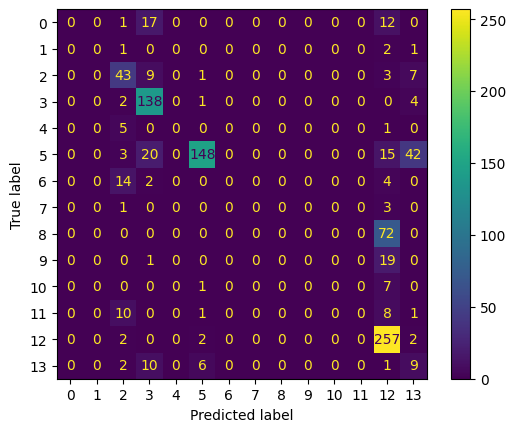


Brand Metrics
              precision    recall  f1-score   support

           0       0.93      0.34      0.50        82
           1       0.36      0.15      0.22       131
           2       0.00      0.00      0.00        37
           3       1.00      0.85      0.92        41
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        81
           7       0.00      0.00      0.00        40
           8       0.90      0.82      0.86        22
           9       0.00      0.00      0.00        41
          10       0.68      0.41      0.51       106
          11       0.09      0.97      0.17        61
          12       0.00      0.00      0.00        31
          13       1.00      0.42      0.59       152

    accuracy                           0.29       911
   macro avg       0.36      0.28      0.27       911
weighted avg       0.46      0.29      0.31       911



C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

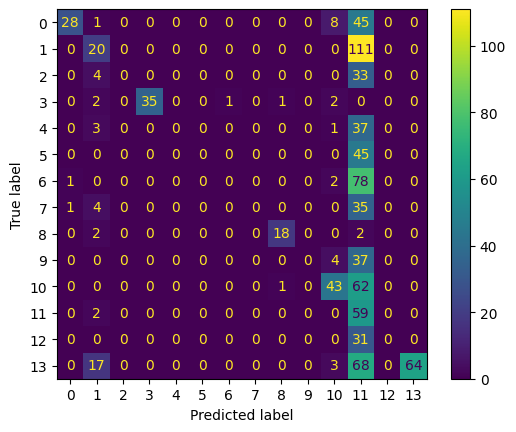

Testing DataLoader 0: 100%|██████████| 4/4 [00:05<00:00,  0.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_brand_accuracy      0.2930845320224762
      test_brand_f1         0.26873794198036194
    test_cat_accuracy        0.653128445148468
       test_cat_f1          0.22264587879180908
 test_exact_match_ratio     0.19319428503513336
        test_loss            4.204935550689697
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 4.204935550689697,
  'test_cat_f1': 0.22264587879180908,
  'test_cat_accuracy': 0.653128445148468,
  'test_brand_f1': 0.26873794198036194,
  'test_brand_accuracy': 0.2930845320224762,
  'test_exact_match_ratio': 0.19319428503513336}]

In [32]:
trainer.test(model, test_loader)

In [23]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\horas\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0:  25%|██▌       | 1/4 [00:00<00:00, 13.86it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


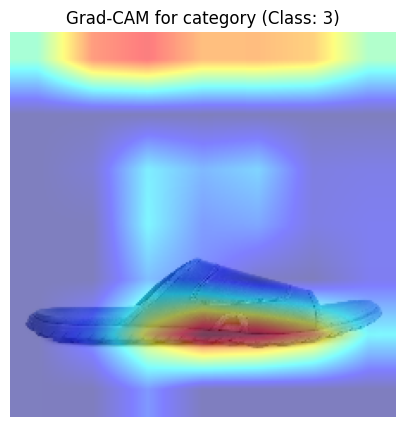

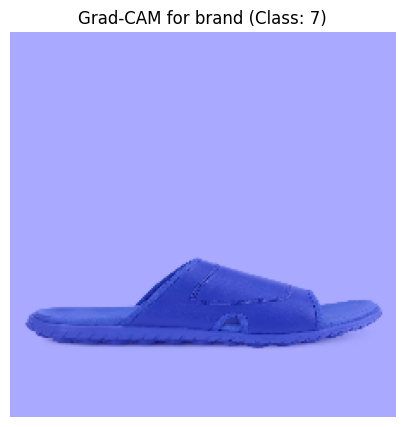

In [22]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

class VITWithGradCAM(VIT):
    def __init__(self, n_category, n_brand):
        super().__init__(n_category, n_brand)

    def visualize_gradcam(self, input_tensor, label_type="category", target_index=None):
        """
        Visualize Grad-CAM for the given label type.

        Args:
            input_tensor (torch.Tensor): Input image tensor of shape [B, C, H, W].
            label_type (str): "category" or "brand" to specify the label type.
            target_index (int): Class index to visualize Grad-CAM for (default is the predicted class).
        """
        self.eval()  # Ensure the model is in evaluation mode
        target_layer = self.resnet.layer4  # Specify the layer for Grad-CAM

        # Move model and input to the same device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        input_tensor = input_tensor.to(device)

        # Initialize Grad-CAM
        cam = GradCAM(model=self, target_layers=[target_layer])

        # Forward pass to get logits
        cat_logits, brand_logits = self.forward(input_tensor)

        # Select the logits and target index based on label type
        if label_type == "category":
            logits = cat_logits
        elif label_type == "brand":
            logits = brand_logits
        else:
            raise ValueError("label_type must be 'category' or 'brand'")

        if target_index is None:
            target_index = logits.argmax(dim=1).item()  # Use the predicted class by default

        # Use ClassifierOutputTarget to define the target class
        targets = [ClassifierOutputTarget(target_index)]


        # Compute Grad-CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

        # Convert input image to numpy and normalize for visualization
        input_image = input_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())

        # Overlay Grad-CAM on the image
        cam_image = show_cam_on_image(input_image, grayscale_cam[0], use_rgb=True)

        # Display the Grad-CAM visualization
        plt.figure(figsize=(10, 5))
        plt.imshow(cam_image)
        plt.title(f"Grad-CAM for {label_type} (Class: {target_index})")
        plt.axis("off")
        plt.show()

# Example Usage
model = VITWithGradCAM(n_category=10, n_brand=5)  # Example model with 10 categories and 5 brands

# Assuming you have an input image tensor
input_image = train_set[1][0].unsqueeze(0)  # Replace with your actual input image
model.visualize_gradcam(input_image, label_type="category")  # Grad-CAM for category
model.visualize_gradcam(input_image, label_type="brand")  # Grad-CAM for brand


In [108]:
train_set[0][0].shape

torch.Size([3, 224, 224])

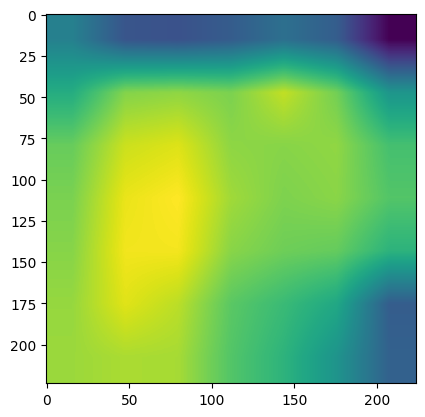

In [105]:
plt.imshow(grayscale_cam)

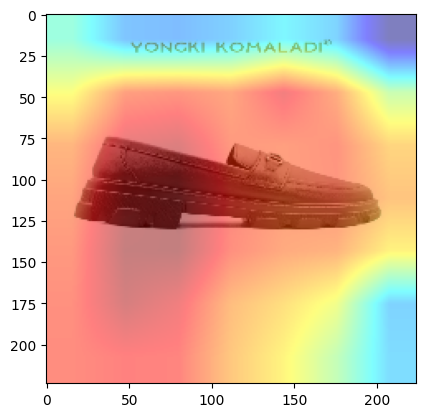

In [77]:
plt.imshow(visualization)

ValueError: x and y must have same first dimension, but have shapes (12,) and (11,)

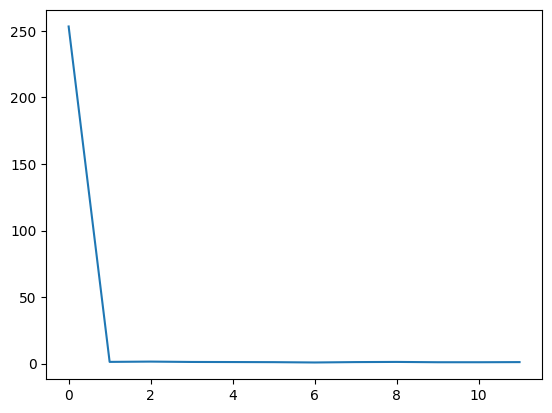

In [41]:
plt.plot(range(len(model.val_epochs_loss)), model.val_epochs_loss)
plt.plot(range(len(model.val_epochs_loss)), model.train_epochs_loss)

In [44]:
len(model.train_epochs_loss)

11

In [45]:
model.train_epochs_loss

[1.7463312032913665,
 1.0274314383120489,
 0.8097839730533104,
 0.6582010398760978,
 0.5484813167606241,
 0.5044803850140124,
 0.4500593156640701,
 0.39468983847864636,
 0.3665382185670763,
 0.34031130603497234,
 0.3258708256437892]